## Google Colab Only - Download Source Code and Data

The download code is hosted on sharepoint, since we need to keep parts of the code private. If the download links doesn't work, please contact hy.gui@mail.utoronto.ca

In [1]:
from __future__ import annotations
import os


def download_src(re_download: bool = False):
    if not re_download and os.path.isfile('requirements.txt'):
        print('Source code exists, skipping download...')
        return

    !wget -O code.zip "https://codeload.github.com/hykilpikonna/P4-CRISTAL-Replication/zip/refs/heads/main" -q --show-progress
    !unzip code.zip
    !mv P4-CRISTAL-Replication-main/* .
    !rm code.zip


download_src()

Source code exists, skipping download...


In [ ]:
def download_data(re_download: bool = False):
    if not re_download and os.path.isdir('github'):
        print('Data exists, skipping download...')
        return

    if not os.path.isfile('data.tar.zst'):
        !wget -O data.tar.zst "https://hydevelop-my.sharepoint.com/:u:/g/personal/me_hydev_org/EbofDOyJNrhGlWAeb4xbS6MBKToILLw5rk8jMFKKjYDULg?download=1" -q --show-progress

    !echo 'Installing ZSTD'
    !apt update > apt.log 2>/dev/null && apt install gzip zstd pv -y >> apt.log 2>/dev/null \
            && echo 'ZSTD Installed Successfully' || echo 'ZSTD Install Failed (check apt.log)'

    !echo 'Extracting...'
    # !pv data.tar.zst -f | tar -I zstd -x
    !tar -I zstd -x -f data.tar.zst --checkpoint=.4096 --totals


download_data()

# -1: Environment Setup

### Install Dependencies

In [1]:
!python -VVV

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]


In [2]:
!pip install -r requirements.txt -q

In [3]:
from __future__ import annotations

import json
import os
import shlex
import tempfile
import warnings
import xml.etree.ElementTree as ET
from datetime import datetime
from pathlib import Path
from subprocess import check_output, check_call
from typing import NamedTuple

import dateutil.parser
import nltk
import pandas as pd
from hypy_utils import json_stringify
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')

In [5]:
apps: dict[str, str] = json.loads(Path('other_data/app_sets/selected_apps.json').read_text())
print('Number of selected apps/repos:', len(apps))

Number of selected apps/repos: 637


In [6]:
DIR_GITHUB = Path('github')
DIR_REVIEWS = Path('reviews')

DIR_REPO_ISSUES =         lambda repo: DIR_GITHUB / 'repos' / repo / 'issues.json'
DIR_REPO_ISSUE_COMMENTS = lambda repo, issue: DIR_GITHUB / 'repos' / repo / 'issues' / str(issue) / 'comments.json'
DIR_REPO_COMMITS =        lambda repo: DIR_GITHUB / 'commits' / repo / 'commits.json'
DIR_REPO_STRINGS_XML =    lambda repo: DIR_GITHUB / 'source' / 'strings.xml' / f"{repo.replace('/', '-')}.xml"
DIR_REPO_LOC =            lambda repo: DIR_GITHUB / 'source' / 'loc' / f"{repo.replace('/', '-')}.txt"

DIR_APP_REVIEWS =         lambda pkg: DIR_REVIEWS / 'play_store' / f'{pkg}.json'
DIR_APP_REVIEWS_PRED =    lambda pkg: DIR_REVIEWS / 'play_store_pred' / f'{pkg}.json'
DIR_APP_RELEASES =        lambda pkg: DIR_REVIEWS / 'f_droid_releases' / f'{pkg}.json'

# 2. Data Collection, Cleaning, Preprocessing

### 2.1. Issue Extractor (Cleaning Existing Data)

In [7]:
import shutil


class ExtractedIssue(NamedTuple):
    id: int
    title: str
    desc: str
    author: str

    # Dates
    opened: str
    modified: str
    closed: str | None

    comments: list[ExtractedComment]


class ExtractedComment(NamedTuple):
    issue: int
    author: str
    date: str
    text: str


def issue_extract(repo: str) -> list[ExtractedIssue]:
    """
    From raw GitHub data, collect title, description, author, open/close time, and comments of issues

    :param repo: GitHub repo in the format of "owner/repo"
    """
    issues = json.loads(DIR_REPO_ISSUES(repo).read_text('utf-8'))
    comments = {i['number']: DIR_REPO_ISSUE_COMMENTS(repo, i['number']) for i in issues}
    comments = {id: json.loads(path.read_text('utf-8')) if path.is_file() else [] for id, path in comments.items()}
    comments = {id: [ExtractedComment(id, c['user']['login'], c['created_at'], c['body']) for c in cs] for id, cs in comments.items()}
    issues = [ExtractedIssue(int(i['number']), i['title'], i['body'], i['user']['login'], i['created_at'], i['updated_at'], i['closed_at'], comments[i['number']])
              for i in issues]
    return issues


# Test issue extractor
pd.DataFrame(issue_extract('zxing/zxing'))[:5]

,id,title,desc,author,opened,modified,closed,comments
0,1558,Add zxing-dart link,None,shirne,2022-08-25T01:27:07Z,2022-08-25T01:34:36Z,2022-08-25T01:34:36Z,[]
1,1557,update nu-book/zxing-cpp link,nu-book/zxing-cpp is now reachable under zxing...,axxel,2022-08-24T22:38:53Z,2022-08-24T22:45:12Z,2022-08-24T22:45:12Z,[]
2,1556,"QR Code Scans on zxing.org, but not in Browser...",The following QR code scans in the zxing.org w...,wisefool769,2022-08-24T21:08:49Z,2022-08-24T23:17:18Z,2022-08-24T21:19:12Z,"[(1556, srowen, 2022-08-24T21:19:12Z, You can ..."
3,1555,auto zoom?,"Hello, does zxing have long-distance automatic...",langyangyangzzZ,2022-08-22T01:31:18Z,2022-08-22T22:45:52Z,2022-08-22T01:40:31Z,"[(1555, srowen, 2022-08-22T01:40:31Z, It just ..."
4,1554,Can you support the OpenHarmony JavaScript ver...,I am developing an OpenHarmony application wit...,DoraCoder,2022-08-17T08:52:38Z,2022-08-17T12:05:37Z,2022-08-17T12:05:37Z,"[(1554, srowen, 2022-08-17T12:05:37Z, No there..."


### 2.2. Commit Extractor (Gathering New Data)

Also collects strings.xml

In [8]:
class ExtractedCommit(NamedTuple):
    sha: str
    author: str
    email: str
    time: str
    message: str
    file_names: list[str]

    def get_time(self) -> datetime:
        return dateutil.parser.isoparse(self.time)


def git_log(path: Path) -> list[ExtractedCommit]:
    """
    Call and parse git log. This function requires that git>=2.37.1 is installed on your system.

    :param path: Path of git repository
    :return: List of commits
    """
    # check_call(shlex.split('git config diff.renames 0'))
    cmd = f"git -c 'diff.renamelimit=0' -c 'diff.renames=0' -C '{path.absolute()}' log --name-status --diff-filter=AMD --pretty=format:'START_COMMIT_QwQ %H%n%aN%n%aE%n%aI%n%s%n'"
    log = check_output(shlex.split(cmd)).decode('utf-8', 'ignore')

    def extract_commit(block: str) -> ExtractedCommit:
        try:
            lines = block.split('\n')
            sha, author, email, date, message = lines + [""] if len(lines) == 4 else lines[:5]
            files = [f.replace('\t', '/') for f in lines[6:]]
            return ExtractedCommit(sha, author, email, date, message, files)
        except Exception as e:
            print(f'========== Commit Extract Error {e} ==========\n{block}\n==========')

    return [extract_commit(c.strip()) for c in log.split('START_COMMIT_QwQ') if c]


def find(name: str, path: Path) -> Path:
    for root, dirs, files in os.walk(path):
        if name in files:
            return Path(root, name)


def commit_collect(repo: str, verbose: bool = False) -> list[ExtractedCommit]:
    """
    Extract commits from GitHub repo, collect sha, time, file names, author, message

    Also extracts strings.xml for GUI terms exclusion.
    Also counts the number of lines of java code.

    :param repo:
    :param verbose:
    :return:
    """
    out_path = DIR_REPO_COMMITS(repo)
    strings_out = DIR_REPO_STRINGS_XML(repo)
    strings_out.parent.mkdir(parents=True, exist_ok=True)
    loc_out = DIR_REPO_LOC(repo)
    loc_out.parent.mkdir(parents=True, exist_ok=True)

    if out_path.is_file():
        return [ExtractedCommit(*d) for d in json.loads(out_path.read_text('utf-8'))]

    with tempfile.TemporaryDirectory() as tmp:
        tmp = Path(tmp)

        # tmp = Path(f'/tmp/github/{repo}')
        # tmp.mkdir(parents=True, exist_ok=True)

        # Clone repository
        if verbose:
            print(f'Cloning {repo} into {tmp}')
        if not (tmp / '.git').is_dir():
            check_call(shlex.split(f'git clone --quiet "https://github.com/{repo}" "{tmp}"'))

        # Extract strings.xml
        strings = find('strings.xml', tmp)
        if strings is not None:
            shutil.copyfile(strings, strings_out)

        # Count lines of java code
        java_files = [Path(root, f) for root, dirs, files in os.walk(tmp) for f in files if f.endswith('java')]
        loc = sum(f.read_bytes().decode('utf-8', 'ignore').count('\n') for f in java_files)
        loc_out.write_text(str(loc))

        # Get git log to json
        commits = git_log(tmp)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_text(json_stringify(commits), 'utf-8')
        return commits


# Test commit extract
pd.DataFrame(commit_collect('zxing/zxing'))[:5]

,sha,author,email,time,message,file_names
0,45df47022794eedcffd7e4409200100be5b8e631,Sean Owen,srowen@gmail.com,2022-07-20T13:29:55-05:00,"Add basic support for thread interruption, and...",[M/core/src/main/java/com/google/zxing/MultiFo...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:36:01-04:00,Add description for OkapiBarcode project (#1545),[M/README.md]
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:12:52-04:00,Fix Maxicode decoding of CR (carriage return);...,[M/core/src/main/java/com/google/zxing/maxicod...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,Sean Owen,srowen@gmail.com,2022-07-06T13:16:34-05:00,Misc dependency updates,"[M/core/pom.xml, M/core/src/main/java/com/goog..."
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,Sean Owen,srowen@gmail.com,2022-07-05T18:34:45-05:00,"In multi QR code finder, only consider multipl...",[M/core/src/main/java/com/google/zxing/multi/q...


### 2.3. Download Commits for All Apps

In [9]:
from hypy_utils.tqdm_utils import pmap

_ = pmap(commit_collect, apps.values(), desc='Caching commits...')

Caching commits...: 100%|██████████| 637/637 [01:01<00:00, 10.44it/s]


### 2.4. Preprocessing Commits & Issues

In [10]:
import string
from hypy_utils.nlp_utils import camel_split
from nltk.stem import PorterStemmer


STOPWORDS = {w.lower() for w in set(Path('other_data/p4-stopwords.txt').read_text('utf-8').splitlines())\
    .union(stopwords.words('english'))}
STEMMER = PorterStemmer()


def gui_keywords(repo: str) -> set[str]:
    """
    Get the set of GUI-keywords from strings.xml
    """
    strings_xml = DIR_REPO_STRINGS_XML(repo)

    if not strings_xml.is_file():
        return set()

    return {w.lower() for el in ET.parse(strings_xml).getroot().iter('string') for w in el.attrib['name'].split('_')}


def process_text(text: str, stop: set[str]) -> str:
    """
    Camel case splitting, underscore splitting, stopword removal, stem

    :param text: Original text
    :param stop: Stopword set to use
    :return: Processed text
    """
    # Remove links
    text = ' '.join(t for t in text.split(' ') if not (t.startswith('http://') or t.startswith('https://')))

    # Remove punctuations (replace punctuations with spaces)
    text = ''.join(c if c not in string.punctuation else ' ' for c in text)
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Tokenize
    text = nltk.word_tokenize(text)

    # Camel split
    text = [s for w in text for s in camel_split(w)]

    # Remove stopwords and stem
    text = [STEMMER.stem(w) for w in text if w not in stop]

    # Join
    return ' '.join(text)


def preprocess_issues(repo: str) -> dict[int, str]:
    """
    Preprocess issues for repo

    :param repo:
    :return: dict[issue_id] = preprocessed issue text
    """
    issues: list[ExtractedIssue] = issue_extract(repo)

    # Combine title and body
    issues: dict[int, str] = {i.id: f'{i.title} {i.desc}' for i in issues}

    # Process text
    issues = {id: process_text(text, STOPWORDS - gui_keywords(repo)) for id, text in issues.items()}

    return issues


def preprocess_commits(repo: str) -> dict[str, str]:
    """
    Preprocess commits for repo

    :param repo:
    :return: dict[commit_hash] = preprocessed commit text
    """
    commits: list[ExtractedCommit] = commit_collect(repo)

    # Combine commit message with names modified (without extensions)
    commits: dict[str, str] = {c.sha: c.message + ' ' + '  '.join(Path(f).stem for f in c.file_names) for c in commits}

    # Process text
    commits = {sha: process_text(text, STOPWORDS - gui_keywords(repo)) for sha, text in commits.items()}

    return commits


pd.DataFrame(preprocess_commits('zxing/zxing').items(), columns=['sha', 'processed'])[:10]

,sha,processed
0,45df47022794eedcffd7e4409200100be5b8e631,add basic interrupt add protect run request we...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,add descript okapi barcod project 1545 readm
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,fix maxicod decod cr carriag fix 1543 1544 dec...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,misc depend updat pom bit matrix eci string bu...
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,in multi qr code finder consid multipli center...
5,75dbbb00dd10a5f3683553e1d56b8209b9db48e2,micro optim to help high level encod
6,78faea80583e6fc903bdb8c146e8ff499b60c307,prevent encod empti pdf417 1523 pd f417 high l...
7,c7a7b30f0497e01bed97fd465e4645594ee35fda,add orient pdf417 barcod to result metadata 15...
8,83cdc82aa15feb819f7ee4906d473874fbf4c93a,updat queri mobil web page add integr to sure ...
9,3aa3832840af45083a10ee6a9247c4f82988d120,readm md descript nu book 1521 readm


### 2.5. Load Reviews Data

In [11]:
class ExtractedReview(NamedTuple):
    id: str
    score: int
    text: str
    version: str
    date: str

    # Informativeness predicted by AR-Miner
    informative: bool
    # Language predicted by langid
    lang: str


def load_reviews(app: str) -> list[ExtractedReview]:
    """
    Load reviews of an app

    :param app: App package name
    :return: Reviews
    """
    return [ExtractedReview(*[r[k] for k in ['id', 'score', 'text', 'version', 'date', 'pred_informative', 'pred_language']])
            for r in json.loads(DIR_APP_REVIEWS_PRED(app).read_text())]


pd.DataFrame(load_reviews('a2dp.Vol')).sample(200).to_csv('informative_eval.csv', index=False)
pd.DataFrame(load_reviews('a2dp.Vol'))[:10]

,id,score,text,version,date,informative,lang
0,b1fc6681-4f28-4c03-851e-3384c6d2dcbd,5,I love this app this app solve my problem abou...,2.13.0.4,2022-08-15T13:40:10.442Z,True,en
1,b1075cba-5348-47b8-b94d-ea6c0b9bbf2a,5,Excellent,None,2022-06-21T20:11:42.723Z,False,de
2,c1f6bf41-5d2e-4900-83ae-3f16d2d32710,5,I Love this app! Love it!,2.13.0.4,2021-11-24T01:22:28.905Z,False,en
3,6c856fdf-10b4-41f1-b456-003c6bdb56dd,5,LsabethDixon Save,2.13.0.4,2021-10-21T16:47:37.307Z,True,en
4,1d014efe-b7d4-4052-a524-e971860d100e,1,Garbage,None,2021-08-09T07:29:27.390Z,True,en
5,9e119827-e4f9-4f39-8d95-caf8bb1c622d,5,Best,2.12.9.3,2021-04-15T10:57:46.540Z,False,en
6,f531887e-1ce5-4c67-b40d-e4f485fe1a04,5,Great for car / headphone pairing. Also reads ...,2.13.0.4,2021-02-16T12:20:19.290Z,False,en
7,17d6dc23-323a-40f8-bd12-97355b9bb474,5,App is good for my stupid MIUI12 not memorizin...,None,2020-12-20T21:23:43.183Z,False,en
8,a76bffa4-2e12-4a71-8a60-0ba10aa87924,1,Notthing worked,None,2020-12-01T07:43:25.731Z,True,en
9,0d959d21-9701-4adc-bc77-e5b97c055299,1,"Does nothing. Unfriendly UI.No info, no help, ...",2.13.0.4,2020-11-09T20:30:29.165Z,True,en


# 3. Link Identifier

## 3.1. Link Issue/Commit to Reviews

Using Asymmetric Dice similarity

In [ ]:
from hypy_utils.tqdm_utils import pmap


SIMILARITY_THRESHOLD = 0.3


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str):
    """
    Link issues and commits to reviews

    :param app: App package name
    :return:
    """
    repo = apps[app]

    out = Path(f'p4-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    reviews, issues, commits = load_reviews(app), issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Filter reviews (informative and english reviews only)
    # reviews = [r for r in reviews if r.informative and r.lang == 'en']
    reviews = [r for r in reviews if r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}

        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            text_sim = len(review_words.intersection(target_words)) / min_len

            # GUI Bonus
            gui_ir = gui_kw.intersection(review_words)
            gui_is = gui_kw.intersection(target_words)
            bonus = len(gui_ir.intersection(gui_is)) / len(review_words.union(target_words))

            final_sim = text_sim * 0.5 + bonus * 0.5
            if final_sim >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    out.parent.mkdir(parents=True, exist_ok=True)
    out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

In [13]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'process/cir-links/{a}').read_text()) for a in os.listdir(f'process/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()

There are a total of 474854 reviews.
136987 (28.8%) reviews linked with at least one issue
51578 (10.9%) reviews linked with at least one commit
38829 (8.2%) reviews linked with at least one issue and one commit
Average number of issues linked (ignoring zeros): 21.7
Average number of commits linked (ignoring zeros): 4.5


## 3.2. Linking Commits to Issues

Using the ReLink approach by Wu et al. (2011)

ReLink runs very slowly. If you want to rerun ReLink, you can download the ReLink and extract it to the bin folder.

```
bin
└── relink
    ├── ReLink.jar
    ├── dictionary
    │   └── dict
    │       ├── adj.exc
    │       ├── adv.exc
    │       ├── cntlist
    │       ├── cntlist.rev
    │       ├── data.adj
    │       ├── data.adv
    │       ├── data.noun
    │       ├── data.verb
    │       ├── frames.vrb
    │       ├── index.adj
    │       ├── index.adv
    │       ├── index.noun
    │       ├── index.sense
    │       ├── index.verb
    │       ├── log.grind.2.1
    │       ├── noun.exc
    │       ├── sentidx.vrb
    │       ├── sents.vrb
    │       ├── verb.Framestext
    │       └── verb.exc
    ├── file_properties.xml
    └── pattern.txt
```

For ReLink, we also need to set up Java

In [14]:
!java --version

openjdk 17.0.4.1 2022-08-12
OpenJDK Runtime Environment (build 17.0.4.1+1)
OpenJDK 64-Bit Server VM (build 17.0.4.1+1, mixed mode)


In [15]:
from hypy_utils.tqdm_utils import pmap


RELINK_BIN = Path('./bin/relink')


def timestamp(iso_date: str) -> int:
    """
    Convert iso date string to java milliseconds timestamp for ReLink
    """
    return int(dateutil.parser.isoparse(iso_date).timestamp() * 1000)


def to_tsv(data: list[list[str]]) -> str:
    """
    Convert list of tuples to ReLink readable tab-separated values text format
    """
    return '\n'.join(['\t'.join([str(v).replace('\t', ' ').replace('\r', ' ').replace('\n', ' ') for v in tup]) for tup in data])


def relink_write_bug_data(repo: str, bug_data_path: Path, bug_comments_path: Path):
    """
    Generate ReLink's BugData.txt (issues) input file and BugCommentData.txt (issue comments) input file.

    As stated in ReLink's readme file:

    > Bug-data file provides the basic bug information.
    > The format of the file is: bugID, Type Status, Owner, Reporter, ReportDate, ModifiedDate, LastDate, Summary, Comments
    > Bug-comment file provides the comments from the developers and the users.
    > The format of the file is: bugID, developer, date, comment
    """
    issues = issue_extract(repo)
    fields = [(i.id, 'Defect', 'Fixed', i.author, i.author, timestamp(i.opened), timestamp(i.modified), timestamp(i.closed), i.title, i.desc, '',
               *(c.author for c in i.comments))
              for i in issues if i.closed]
    bug_data_path.write_text(to_tsv(fields))
    comments = [(i.id, c.author, timestamp(c.date), c.text) for i in issues for c in i.comments if i.closed]
    bug_comments_path.write_text(to_tsv(comments))


def relink_write_changelogs(repo: str, changelog_path: Path):
    """
    Generate ReLink's changeLogs.txt (commits) input file.

    As stated in ReLink's readme file:

    > Change-log file provides the basic change log information.
    > The format of the file is: revisionNo, date, Author, Message

    However, in the example file, the format is: revisionNo, date, author, message + files, message
    """
    commits = commit_collect(repo)

    def transform_file(file: str):
        for short, full in [('A/', 'Added : '), ('M/', 'Modified : '), ('D/', 'Deleted : ')]:
            if file.startswith(short):
                return f'{full}{file[len(short):]}'
        print(f'Error parsing {file}')
        return file

    fields = [(i, timestamp(c.time), c.author, c.message + ' ' + ' '.join(transform_file(f) for f in c.file_names), c.message)
              for i, c in enumerate(commits)]
    changelog_path.write_text(to_tsv(fields))


def relink_run(repo: str):
    with tempfile.TemporaryDirectory() as tmp:
        tmp = Path(tmp)

        tmp = Path(f'/tmp/relink/{repo}')
        tmp.mkdir(parents=True, exist_ok=True)

        # Create output path
        out_path = Path(f'./p4-processed/relink/{repo}').absolute()
        out_path.mkdir(parents=True, exist_ok=True)
        if not (out_path / "links.txt").is_file():
            (out_path / "links.txt").write_text('')

        # Ignore already processed items
        if (out_path / 'index' / 'final_results.txt').is_file():
            print(f'Skipped {repo}')
            return

        # Create data files
        bug_data = tmp / 'BugData.txt'
        bug_comment = tmp / 'BugCommentData.txt'
        relink_write_bug_data(repo, bug_data, bug_comment)

        changelog = tmp / 'changeLogs.txt'
        relink_write_changelogs(repo, changelog)

        # Run relink
        log = (out_path / 'logs.txt').open('a')
        cmd = f'java -jar "{tmp}/relink/ReLink.jar" {bug_data} {bug_comment} {changelog} {out_path / "index"} -g {out_path / "links.txt"}'
        log.write(cmd + '\n\n')
        if not os.path.islink(tmp / 'relink'):
            check_call(shlex.split(f'ln -sf {RELINK_BIN.absolute()} {tmp}/relink'), cwd=tmp, stdout=log, stderr=log)
        check_call(shlex.split(cmd), cwd=tmp / 'relink', stdout=log, stderr=log)


# relink_run('zxing/zxing')

# Multiprocessing
# pmap(relink_run, list(apps.values()), desc='Running Relink', unit="apps")

# RQ1 - CRISTAL Linking Accuracy

### Table Generation

#### Table 1: List of apps used for manual evaluation

In [16]:
from hypy_utils.tqdm_utils import tq
import io
import requests
import zipfile


def get_f_droid_index() -> dict[str, dict]:
    """
    Get F-Droid Index
    """
    buf = requests.get('https://f-droid.org/repo/index-v1.jar').content
    j = zipfile.ZipFile(io.BytesIO(buf)).read('index-v1.json')
    lst = json.loads(j)['apps']
    return {a['packageName']: a for a in lst}

In [17]:
from bs4 import BeautifulSoup
from hypy_utils.tqdm_utils import pmap


class AppRelease(NamedTuple):
    ver: str
    ver_num: int
    date: str


def crawl_release_dates(pkg: str) -> list[AppRelease]:
    out_path = DIR_APP_RELEASES(pkg)
    if out_path.is_file():
        return [AppRelease(*e) for e in json.loads(out_path.read_text())]

    html = requests.get(f'https://f-droid.org/en/packages/{pkg}').text
    soup = BeautifulSoup(html)
    releases = []
    for version in soup.select('.package-version'):
        version_block = version.select_one('.package-version-header')
        ver, ver_num = [a.attrs['name'] for a in version_block.select('a')]
        date = version_block.text.split('Added on')[1].strip()
        releases.append(AppRelease(ver, int(ver_num), date))

    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(releases))

    return releases


_ = pmap(crawl_release_dates, list(apps.keys()))

100%|██████████| 637/637 [00:13<00:00, 48.05it/s]


In [19]:
manual_app_names = {}


def table_1(apps: list[tuple[str, str]]) -> pd.DataFrame:
    """
    Table 1: List of apps used for manual evaluation

    Includes name, version, kloc, number of reviews, number of commits, number of issues

    :return: Table
    """
    fd = get_f_droid_index()
    apps = [(pkg, fd.get(pkg) or fd.get(pkg + '.foss'), repo)
            for pkg, repo in apps if pkg in fd or pkg + '.foss' in fd]
    table = []
    for pkg, a, repo in tq(apps, 'Generating table 1...'):
        releases = crawl_release_dates(pkg)
        if len(releases) == 0:
            releases = crawl_release_dates(pkg + '.foss')

        latest: AppRelease = releases[0]
        previous: AppRelease = releases[1]

        # At least 20 days
        if timestamp(latest.date) - timestamp(previous.date) < 1000 * 60 * 60 * 24 * 20:
            previous = releases[2]

        latest_ts = timestamp(latest.date)
        previous_ts = timestamp(previous.date)

        reviews = [r for r in load_reviews(pkg) if latest_ts > timestamp(r.date) > previous_ts]
        informative = [r for r in reviews if r.informative]

        commits = commit_collect(repo)
        commits_relevant = [c for c in commits if timestamp(c.time) > previous_ts]
        issues = issue_extract(repo)
        issues_relevant = [i for i in issues if timestamp(i.opened) > previous_ts]

        # Store manual evaluation sets
        path = Path(f'manual_eval/{pkg}')
        path.mkdir(parents=True, exist_ok=True)
        pd.DataFrame(informative).to_csv(path / 'informative_reviews.csv')
        pd.DataFrame(commits_relevant).to_csv(path / 'relevant_commits.csv')
        pd.DataFrame(issues_relevant).to_csv(path / 'relevant_issues.csv')

        name = (a['localized'].get('en-US') or next(iter(l for l in a['localized'].values() if 'name' in l), pkg))['name']
        manual_app_names[pkg] = name

        table.append({
            'name': name,
            'latest': f'{latest.ver}',
            'time-interval': f'{previous.date} to {latest.date}',
            'kloc': int(DIR_REPO_LOC(repo).read_text()) // 1000,
            'reviews (informative)': f'{len(reviews)} ({len(informative)})',
            'commits (relevant)': f'{len(commits)} ({len(commits_relevant)})',
            'issues (relevant)': f'{len(issues)} ({len(issues_relevant)})'
        })
    return pd.DataFrame(table)


manual_apps = ['dev.ukanth.ufirewall', 'de.danoeh.antennapod', 'com.fsck.k9', 'com.owncloud.android', 'org.mariotaku.twidere', 'com.foobnix.pro.pdf.reader', 'be.mygod.vpnhotspot', 'com.ichi2.anki', 'im.vector.app', 'com.google.zxing.client.android']
manual_apps = [(a, r) for a, r in apps.items() if a in manual_apps]
print(len(manual_apps))
table_1(manual_apps)

9


Generating table 1...: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


,name,latest,time-interval,kloc,reviews (informative),commits (relevant),issues (relevant)
0,AFWall+,3.5.3,2021-05-25 to 2022-07-03,32,39 (23),1668 (47),1152 (88)
1,AnkiDroid,2.15.6,2021-06-07 to 2021-07-20,31,559 (119),13401 (3106),12165 (3092)
2,AntennaPod,2.6.2,2022-07-12 to 2022-08-07,68,36 (12),5965 (3),6017 (75)
3,Barcode Scanner,4.7.8,2017-11-14 to 2018-09-20,72,621 (242),3576 (265),1505 (610)
4,Element - Secure Messenger,1.4.32,2022-07-03 to 2022-08-15,4,24 (13),14660 (332),6908 (499)
5,K-9 Mail,6.301,2022-07-19 to 2022-08-11,71,42 (27),9319 (125),6210 (88)
6,Librera Reader,8.5.45-fdroid,2022-07-24 to 2022-08-19,229,7 (2),3769 (4),889 (21)
7,ownCloud,2.21.1,2022-05-18 to 2022-06-20,31,6 (3),8591 (49),3727 (68)
8,Twidere,4.1.8,2021-03-17 to 2021-04-26,52,15 (9),3061 (7),1450 (30)


### Table 3: Recall, Precision, F1 when considering issues only

In [55]:
import math


def table_3(apps: list[tuple[str, str]], attr: str):
    """
    Generate tables 3, 4

    :param apps: List of apps [package name, repo]
    :param attr: Can be "issues" or "commits" - Only issues or only commits
    :return: Table DataFrame
    """
    table = []
    for pkg, repo in tq(apps, 'Generating table 3...'):
        reviews = pd.read_csv(f'manual_eval/{pkg}/informative_reviews.csv')

        # Filter manual reviews
        filter = lambda r: None if (isinstance(r, float) and math.isnan(r)) or str(r).lower() == 'none' else str(r).replace('.0', '').split(',')
        reviews['linked_issues'] = [filter(r) for r in reviews['linked_issues']]
        reviews['linked_commits'] = [filter(r) for r in reviews['linked_commits']]

        # Load CRISTAL-linked issues
        cristal = link_issues_to_reviews(pkg)

        # Filter out reviews that are not in CRISTAL's list
        # print('===================')
        # print(len(reviews))
        reviews = reviews[reviews.id.isin(cristal)]
        # print(len(reviews))
        reviews['pred_issues'] = [cristal[r]['issues'] for r in reviews.id]
        reviews['pred_commits'] = [cristal[r]['commits'] for r in reviews.id]

        # Filter out non-traceable reviews
        traceable_ratio = sum(reviews.is_traceable_issue) / len(reviews)
        reviews = reviews[reviews.is_traceable_issue == 1]
        # print(len(reviews))
        links = sum(len(i) for i in reviews[f'linked_{attr}'] if i)

        # Count true positives, false positives
        # True positive: An issue/commit found by CRISTAL that's also found by manual evaluators
        # False positive: An issue/commit found by CRISTAL that's not found by manual evaluators
        # False negative: An issue/commit found by manual evaluators that's not found by CRISTAL
        tp, fp, fn = 0, 0, 0
        for i, r in reviews.iterrows():
            linked = {str(v) for v in r[f'linked_{attr}'] or []}
            pred = {str(v) for v in r[f'pred_{attr}'] or []}

            tp += sum(iss in linked for iss in pred)
            fp += len(pred) - tp
            fn += sum(iss not in pred for iss in linked)

        # Calculate precision, recall, f1
        prec = tp / (tp + fp) if tp + fp != 0 else 0
        rec = tp / (tp + fn) if tp + fn != 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if prec + rec != 0 else 0

        table.append({
            'App': manual_app_names[pkg],
            'Traceable (Oracle)': f'{traceable_ratio * 100:.1f}%',
            '#Links (Oracle)': f"{links} ({links / len(reviews) * 100:.1f}%)",
            '#TP': tp,
            '#FP': fp,
            '#FN': fn,
            'prec': f'{prec * 100:.0f}%',
            'recall': f'{rec * 100:.0f}%',
            'f1': f'{f1 * 100:.0f}%',
        })

    df = pd.DataFrame(table)
    df.append(df.sum(numeric_only=True), ignore_index=True)
    return df


print('Table 3: Accuracy achieved by CRISTAL when considering issues only')
table_3(manual_apps, 'issues')

Table 3: Accuracy achieved by CRISTAL when considering issues only


Generating table 3...: 100%|██████████| 9/9 [00:00<00:00, 13.58it/s]


,App,Traceable (Oracle),#Links (Oracle),#TP,#FP,#FN,prec,recall,f1
0,AFWall+,57.9%,3 (27.3%),1,2,2,33%,33%,33%
1,AnkiDroid,24.3%,13 (50.0%),1,193,12,1%,8%,1%
2,AntennaPod,72.7%,0 (0.0%),0,33,0,0%,0%,0%
3,Barcode Scanner,19.0%,3 (7.7%),0,455,3,0%,0%,0%
4,Element - Secure Messenger,60.0%,5 (55.6%),1,111,4,1%,20%,2%
5,K-9 Mail,69.0%,10 (50.0%),0,0,10,0%,0%,0%
6,Librera Reader,100.0%,2 (50.0%),1,0,1,100%,50%,67%
7,ownCloud,33.3%,0 (0.0%),0,2,0,0%,0%,0%
8,Twidere,83.3%,2 (40.0%),0,0,2,0%,0%,0%


In [56]:
print('Table 4: Accuracy achieved by CRISTAL when considering commits only')
table_3(manual_apps, 'commits')

Table 4: Accuracy achieved by CRISTAL when considering commits only


Generating table 3...: 100%|██████████| 9/9 [00:00<00:00, 13.04it/s]


,App,Traceable (Oracle),#Links (Oracle),#TP,#FP,#FN,prec,recall,f1
0,AFWall+,57.9%,0 (0.0%),0,2,0,0%,0%,0%
1,AnkiDroid,24.3%,1 (3.8%),0,8,1,0%,0%,0%
2,AntennaPod,72.7%,0 (0.0%),0,0,0,0%,0%,0%
3,Barcode Scanner,19.0%,1 (2.6%),0,8,1,0%,0%,0%
4,Element - Secure Messenger,60.0%,4 (44.4%),0,0,4,0%,0%,0%
5,K-9 Mail,69.0%,0 (0.0%),0,0,0,0%,0%,0%
6,Librera Reader,100.0%,0 (0.0%),0,0,0,0%,0%,0%
7,ownCloud,33.3%,0 (0.0%),0,0,0,0%,0%,0%
8,Twidere,83.3%,0 (0.0%),0,1,0,0%,0%,0%


### Table 4: Recall, Precision, F1 when considering commits only

One key difference is that, the manual evaluators found a lot (98) review-commit links in CRISTAL while our manual evaluators found very few (6) review-commit links. This is potentially due to differences in data.

# RQ2 - Measure Current Review Fulfillment

"To what extent do developers fulfill reviews when working on a new app release?"

In [67]:
import math
import numpy as np
import statistics


def get_rating_change(pkg: str):
    reviews = load_reviews(pkg)
    releases = crawl_release_dates(pkg)

    reviews = [(timestamp(r.date), r.score) for r in reviews]

    if len(releases) == 0:
        return math.nan

    prev_date = timestamp(releases[1 if len(releases) >= 2 else 0].date)

    try:
        rating_curr = statistics.mean(r for d, r in reviews if d > prev_date)
        rating_prev = statistics.mean(r for d, r in reviews if d <= prev_date)
        return rating_curr - rating_prev

    except statistics.StatisticsError:
        return math.nan


changes = np.array(pmap(get_rating_change, list(apps.keys())), dtype=float)
print(f'Avg rating change: {np.nanmean(changes)}')

100%|██████████| 612/612 [00:02<00:00, 291.77it/s]

Avg rating change: -0.15616796881594


### Table 6 - Selected App Statistics

In [18]:
from collections import Counter


def table_6_helper(tup: tuple):
    pkg, f, repo = tup
    reviews = json.loads(DIR_APP_REVIEWS_PRED(pkg).read_text())
    return f['categories'][0], {
        'Apps': 1, 'Reviews': len(reviews), 'Informative': sum(r['pred_informative'] for r in reviews),
        'KLOC': int(DIR_REPO_LOC(repo).read_text()) / 1000, 'Commits': len(commit_collect(repo)),
        'Issues': len(json.loads(DIR_REPO_ISSUES(repo).read_text()))
    }


def table_6(apps: list[tuple[str, str]]) -> pd.DataFrame:
    fd = get_f_droid_index()
    apps = [(pkg, fd[pkg], repo) for pkg, repo in apps if pkg in fd]
    categories: dict[str, Counter] = {}
    data = pmap(table_6_helper, apps)
    for d in data:
        cat, counter = d
        categories.setdefault(cat, Counter())
        categories[cat].update(counter)
    out = [{'Category': cat, **counter} for cat, counter in categories.items()]
    return pd.DataFrame(out)


table_6(list(apps.items()))

100%|██████████| 603/603 [00:06<00:00, 93.72it/s]


,Category,Apps,Reviews,Informative,KLOC,Commits,Issues
0,Games,45,114391,81882,947.401,128357,59814
1,System,77,75152,54507,527.666,43448,15639
2,Science & Education,27,19114,12969,300.337,33535,19346
3,Theming,19,27561,20123,124.879,13131,3577
4,Time,22,12386,9648,130.616,20453,4736
5,Graphics,6,502,411,49.618,2199,995
6,Multimedia,74,121911,87254,909.467,135417,54199
7,Development,20,23322,13516,324.959,14501,7719
8,Internet,91,99850,72138,3143.301,162116,87053
9,Security,26,10600,8697,337.034,18848,7879


### Figure 4 - Review coverage bar chart

Loading files: 100%|██████████| 612/612 [00:02<00:00, 215.56it/s]


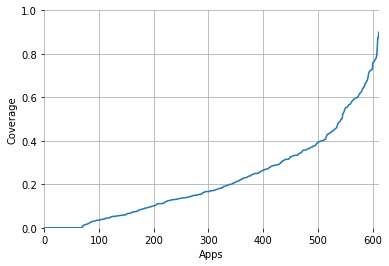

In [65]:
from hypy_utils.scientific_utils import plot, calc_col_stats
from matplotlib import pyplot as plt


def figure_4():
    app_files = os.listdir(f'process/cir-links')
    links = [json.loads(Path(f'process/cir-links/{a}').read_text()) for a in tq(app_files, 'Loading files')]
    percentages = [sum(bool(d['commits'] or d['issues']) for r, d in a.items()) / len(a) for a in links]
    stats = calc_col_stats(percentages)
    app_groups = {'low': [], 'medium': [], 'high': []}
    for f, p in zip(app_files, percentages):
        pkg = f.replace('.json', '')
        if p > stats.upper_quartile:
            app_groups['high'].append(pkg)
        elif p < stats.lower_quartile:
            app_groups['low'].append(pkg)
        else:
            app_groups['medium'].append(pkg)

    percentages.sort()

    plt.autoscale(tight=True)
    plot(plot=percentages, ylim=[0,1], xlabel='Apps', ylabel='Coverage', box=False, grid=True)
    return app_groups


app_groups = figure_4()

# RQ3 - Effect of Crowd Review Mechanism

"What is the effect of a crowd review mechanism (for planning and implementing future changes) on the app success?"

### Figure 5 - BoxPlot of Average Rating Change of the Three Groups

Loading reviews: 100%|██████████| 612/612 [00:00<00:00, 624.27it/s]


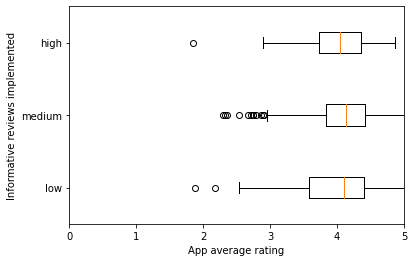

Computing rating change for high group: 100%|██████████| 149/149 [00:01<00:00, 114.18it/s]


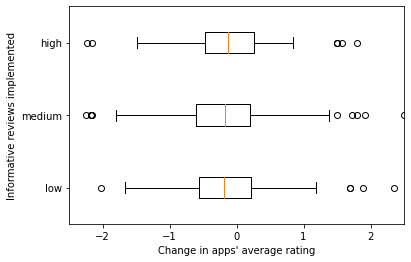

In [73]:
def figure_5_helper(app: str):
    return np.mean([r.score for r in load_reviews(app)])


def figure_5(apps: list[str]) -> dict[str, list[list[float]]]:
    ratings = pmap(figure_5_helper, apps, desc='Loading reviews')
    ratings = dict(zip(apps, ratings))
    groups = {g: [ratings[a] for a in aps] for g, aps in app_groups.items()}
    plt.boxplot(list(groups.values()), labels=list(groups.keys()), vert=False)
    plot(xlim=[0,5], xlabel='App average rating', ylabel='Informative reviews implemented').show()

    groups = {g: [v for v in pmap(get_rating_change, aps, desc=f'Computing rating change for {g} group') if not math.isnan(v)]
              for g, aps in app_groups.items()}
    plt.boxplot(list(groups.values()), labels=list(groups.keys()), vert=False)
    plot(xlim=[-2.5, 2.5], xlabel='Change in apps\' average rating', ylabel='Informative reviews implemented').show()

    return groups


app_group_deltas = figure_5(list(apps.keys()))

### Table 14 - Mann-Whitney test and Cliff's Delta

In [79]:
from itertools import combinations
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu

def table_14() -> pd.DataFrame:
    keys = ['high', 'medium', 'low']
    results = []
    for f, t in list(combinations(keys, 2)):
        delta, remark = cliffs_delta(app_group_deltas[f], app_group_deltas[t])
        results.append({
            'Test': f'{f} vs {t}',
            'p-value': f'{mannwhitneyu(app_group_deltas[f], app_group_deltas[t])[1]:.3f}',
            'd': f'{delta:.2f} ({remark})'
        })
    return pd.DataFrame(results)


table_14()


,Test,p-value,d
0,high vs medium,0.553,0.04 (negligible)
1,high vs low,0.634,0.04 (negligible)
2,medium vs low,0.985,-0.00 (negligible)
